In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
dataset_train = pd.read_csv('pendigits.tra', sep= ',', header=None)

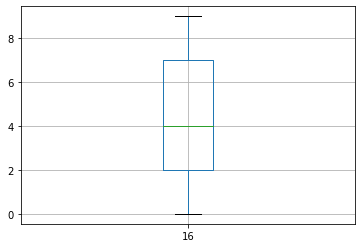

In [4]:
dataset_train.boxplot(column=16)

In [5]:
dataset_train.shape

(7494, 17)

In [6]:
dataset_train.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64')

In [7]:
dataset_test = pd.read_csv('pendigits.tes', sep= ',', header=None)

In [8]:
dataset = dataset_train.append(dataset_test)

In [9]:
y = dataset.values[:,-1]

In [10]:
y

array([8, 2, 1, ..., 0, 0, 4], dtype=int64)

In [11]:
X = dataset.values[:,:-2]

In [12]:
X

array([[ 47, 100,  27, ..., 100,  90,  40],
       [  0,  89,  27, ...,  69,   2, 100],
       [  0,  57,  31, ...,  28,  25,  16],
       ...,
       [ 56, 100,  27, ...,  93,  93,  38],
       [ 19, 100,   0, ...,  62,  97,  10],
       [ 38, 100,  37, ...,  86,  26,  65]], dtype=int64)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [14]:
X_train,  X_val , y_train , y_val = train_test_split(X_train, y_train, test_size= 0.15)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
train_error, test_error = [],[]

In [58]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [59]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

In [20]:
c = dataset.corr().abs()

s = c.unstack()

so = s.sort_values(kind="quicksort")

In [21]:
so = so[so<1.0]

In [22]:
so[-3:]

13  5     0.794761
15  13    0.857205
13  15    0.857205
dtype: float64

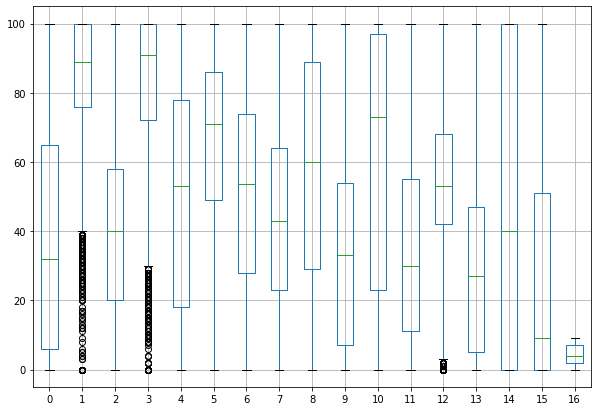

In [32]:
dataset.boxplot(figsize= (10,7))

In [ ]:
for depth_limit in range(1, 20 + 1):
   
    classifier = DecisionTreeClassifier(max_depth= depth_limit, criterion='entropy')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print("Accuracy for depth limit ", depth_limit , ":", accuracy_score(y_test, y_pred) * 100)
    print("Train Score: ", classifier.score(X_train, y_train))
    print("CV Score   : ", cross_val_score(classifier, X_train, y_train , cv=3))
    print("Test  Score: ", classifier.score(X_val, y_val))
    
    train_error.append(1-classifier.score(X_train, y_train))
    test_error.append(1-np.mean(cross_val_score(classifier, X_val, y_val, cv=3)))

In [ ]:
plt.figure()
plt.clf()
plt.plot(train_error, label="Training Error")
plt.plot(test_error, label="Cross Validation Error")
plt.legend(loc=4)
plt.ylim([0, 0.9])
plt.title("Figure 1b: Decision Tree Error vs Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error")


In [ ]:
dataset.isnull().sum()

In [ ]:
plt.figure()
plt.clf()
plt.plot(train_error, label="Training Error")
plt.plot(test_error, label="Cross Validation Error")
plt.legend(loc=4)
plt.title("Figure 1b: Decision Tree Error vs Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error")

In [ ]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def run_gridsearch(X, y, clf, param_grid, cv):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.cv_results_)))

    top_params = report(grid_search.cv_results_, 3)
    return  top_params

In [ ]:
def run_randomsearch(X, y, clf, para_dist, cv,
                     n_iter_search=100):
    """Run a random search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_dist -- [dict] list, distributions of parameters
                  to sample
    cv -- fold of cross-validation, default 5
    n_iter_search -- number of random parameter sets to try,
                     default 20.

    Returns
    -------
    top_params -- [dict] from report()
    """
    random_search = RandomizedSearchCV(clf,
                        param_distributions=param_dist,
                        n_iter=n_iter_search)

    start = time()
    random_search.fit(X, y)
    print(("\nRandomizedSearchCV took {:.2f} seconds "
           "for {:d} candidates parameter "
           "settings.").format((time() - start),
                               n_iter_search))

    top_params = report(random_search.cv_results_, 3)
    return  top_params


In [ ]:
print("-- Random Parameter Search via 3-fold CV")


max_depth = [int(x) for x in np.linspace(10, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = sp_randint(1, 5000)
# Minimum number of samples required at each leaf node
min_samples_leaf = sp_randint(1, 5000)
n_iter_search = 1000
# Method of selecting samples for training each tree
# Create the random grid
param_dist = {
                'max_depth': max_depth,
                "random_state":[100,None],
                "presort": [True, False],
                "class_weight":[ "balanced" , None],
                "criterion": ["gini", "entropy"]}
print(param_dist)




rfc = DecisionTreeClassifier()
ts_rs = run_randomsearch(X_train, y_train, rfc, param_dist, cv=3, n_iter_search=100)

In [ ]:

max_depth = [int(x) for x in np.linspace(10, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = sp_randint(1, 5000)
# Minimum number of samples required at each leaf node
min_samples_leaf = sp_randint(1, 5000)
n_iter_search = 1000
# Method of selecting samples for training each tree
# Create the random grid
param_dist = {
                'max_depth': max_depth,
                "random_state":[100,None],
                "presort": [True, False],
                "class_weight":[ "balanced" , None],
                "criterion": ["gini", "entropy"]}
print(param_dist)




rfc = DecisionTreeClassifier()
ts_rs = run_gridsearch(X_train, y_train, rfc, param_dist, cv=10)